In [36]:
with open('requirements.txt', 'w') as f:
    f.write('absl-py==0.7.0\n')
    f.write('numpy==1.16.4\n')
    f.write('scipy==1.2.0\n')
    f.write('tensorflow==1.15.0\n')
    f.write('tensorflow-gpu==1.15.0\n')
    f.write('tensorflow_probability==0.7.0\n')
    f.write('matplotlib\n')
    f.write('scikit-learn')

In [37]:
!pip install -r requirements.txt

     |████████████████████████████████| 102kB 7.3MB/s 
     |████████████████████████████████| 17.3MB 178kB/s 
     |████████████████████████████████| 26.6MB 123kB/s 
     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 411.5MB 42kB/s 
     |████████████████████████████████| 983kB 38.8MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 512kB 47.9MB/s 
     |████████████████████████████████| 3.8MB 33.0MB/s 
  Created wheel for absl-py: filename=absl_py-0.7.0-cp37-none-any.whl size=113530 sha256=4ec81b1a79d445315d547f453321505c9abd09db9d6b281103a6f2e1490473e5
  Stored in directory: /root/.cache/pip/wheels/90/db/f8/2c3101f72ef1ad434e4662853174126ce30201a3e163dcbeca
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=958b768aced1d2fadf030366058bd6b1f78ad5c069f7f028af212e94d1442cf2
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699f

In [2]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import numpy as np
import pandas as pd
import sys
import os
import time
from datetime import datetime
import matplotlib
from random import randint
%matplotlib inline
matplotlib.use("Agg")
from matplotlib import pyplot as plt
tf.compat.v1.enable_eager_execution()
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
### NN utils ###
def make_nn(output_size, hidden_sizes):
    """ Creates fully connected neural network
            :param output_size: output dimensionality
            :param hidden_sizes: tuple of hidden layer sizes.
                                 The tuple length sets the number of hidden layers.
    """
    layers = [tf.keras.layers.Dense(h, activation=tf.nn.relu, dtype=tf.float32)
              for h in hidden_sizes]
    layers.append(tf.keras.layers.Dense(output_size, dtype=tf.float32))
    return tf.keras.Sequential(layers)


def make_cnn(output_size, hidden_sizes, kernel_size=3):
    """ Construct neural network consisting of
          one 1d-convolutional layer that utilizes temporal dependences,
          fully connected network
        :param output_size: output dimensionality
        :param hidden_sizes: tuple of hidden layer sizes.
                             The tuple length sets the number of hidden layers.
        :param kernel_size: kernel size for convolutional layer
    """
    cnn_layer = [tf.keras.layers.Conv1D(hidden_sizes[0], kernel_size=kernel_size,
                                        padding="same", dtype=tf.float32)]
    layers = [tf.keras.layers.Dense(h, activation=tf.nn.relu, dtype=tf.float32)
              for h in hidden_sizes[1:]]
    layers.append(tf.keras.layers.Dense(output_size, dtype=tf.float32))
    return tf.keras.Sequential(cnn_layer + layers)


def make_2d_cnn(output_size, hidden_sizes, kernel_size=3):
    """ Creates fully convolutional neural network.
        Used as CNN preprocessor for image data (HMNIST, SPRITES)
        :param output_size: output dimensionality
        :param hidden_sizes: tuple of hidden layer sizes.
                             The tuple length sets the number of hidden layers.
        :param kernel_size: kernel size for convolutional layers
    """
    layers = [tf.keras.layers.Conv2D(h, kernel_size=kernel_size, padding="same",
                                     activation=tf.nn.relu, dtype=tf.float32)
              for h in hidden_sizes + [output_size]]
    return tf.keras.Sequential(layers)

In [2]:
### Utils ###
def reduce_logmeanexp(x, axis, eps=1e-5):
    """Numerically-stable (?) implementation of log-mean-exp.
    Args:
        x: The tensor to reduce. Should have numeric type.
        axis: The dimensions to reduce. If `None` (the default),
              reduces all dimensions. Must be in the range
              `[-rank(input_tensor), rank(input_tensor)]`.
        eps: Floating point scalar to avoid log-underflow.
    Returns:
        log_mean_exp: A `Tensor` representing `log(Avg{exp(x): x})`.
    """
    x_max = tf.reduce_max(x, axis=axis, keepdims=True)
    return tf.log(tf.reduce_mean(
            tf.exp(x - x_max), axis=axis, keepdims=True) + eps) + x_max


def multiply_tfd_gaussians(gaussians):
    """Multiplies two tfd.MultivariateNormal distributions."""
    mus = [gauss.mean() for gauss in gaussians]
    Sigmas = [gauss.covariance() for gauss in gaussians]
    mu_3, Sigma_3, _ = multiply_gaussians(mus, Sigmas)
    return tfd.MultivariateNormalFullCovariance(loc=mu_3, covariance_matrix=Sigma_3)


def multiply_inv_gaussians(mus, lambdas):
    """Multiplies a series of Gaussians that is given as a list of mean vectors and a list of precision matrices.
    mus: list of mean with shape [n, d]
    lambdas: list of precision matrices with shape [n, d, d]
    Returns the mean vector, covariance matrix, and precision matrix of the product
    """
    assert len(mus) == len(lambdas)
    batch_size = int(mus[0].shape[0])
    d_z = int(lambdas[0].shape[-1])
    identity_matrix = tf.reshape(tf.tile(tf.eye(d_z), [batch_size,1]), [-1,d_z,d_z])
    lambda_new = tf.reduce_sum(lambdas, axis=0) + identity_matrix
    mus_summed = tf.reduce_sum([tf.einsum("bij, bj -> bi", lamb, mu)
                                for lamb, mu in zip(lambdas, mus)], axis=0)
    sigma_new = tf.linalg.inv(lambda_new)
    mu_new = tf.einsum("bij, bj -> bi", sigma_new, mus_summed)
    return mu_new, sigma_new, lambda_new


def multiply_inv_gaussians_batch(mus, lambdas):
    """Multiplies a series of Gaussians that is given as a list of mean vectors and a list of precision matrices.
    mus: list of mean with shape [..., d]
    lambdas: list of precision matrices with shape [..., d, d]
    Returns the mean vector, covariance matrix, and precision matrix of the product
    """
    assert len(mus) == len(lambdas)
    batch_size = mus[0].shape.as_list()[:-1]
    d_z = lambdas[0].shape.as_list()[-1]
    identity_matrix = tf.tile(tf.expand_dims(tf.expand_dims(tf.eye(d_z), axis=0), axis=0), batch_size+[1,1])
    lambda_new = tf.reduce_sum(lambdas, axis=0) + identity_matrix
    mus_summed = tf.reduce_sum([tf.einsum("bcij, bcj -> bci", lamb, mu)
                                for lamb, mu in zip(lambdas, mus)], axis=0)
    sigma_new = tf.linalg.inv(lambda_new)
    mu_new = tf.einsum("bcij, bcj -> bci", sigma_new, mus_summed)
    return mu_new, sigma_new, lambda_new


def multiply_gaussians(mus, sigmas):
    """Multiplies a series of Gaussians that is given as a list of mean vectors and a list of covariance matrices.
    mus: list of mean with shape [n, d]
    sigmas: list of covariance matrices with shape [n, d, d]
    Returns the mean vector, covariance matrix, and precision matrix of the product
    """
    assert len(mus) == len(sigmas)
    batch_size = [int(n) for n in mus[0].shape[0]]
    d_z = int(sigmas[0].shape[-1])
    identity_matrix = tf.reshape(tf.tile(tf.eye(d_z), [batch_size,1]), batch_size+[d_z,d_z])
    sigma_new = identity_matrix
    mu_new = tf.zeros((batch_size, d_z))
    for mu, sigma in zip(mus, sigmas):
        sigma_inv = tf.linalg.inv(sigma_new + sigma)
        sigma_prod = tf.matmul(tf.matmul(sigma_new, sigma_inv), sigma)
        mu_prod = (tf.einsum("bij,bj->bi", tf.matmul(sigma, sigma_inv), mu_new)
                   + tf.einsum("bij,bj->bi", tf.matmul(sigma_new, sigma_inv), mu))
        sigma_new = sigma_prod
        mu_new = mu_prod
    lambda_new = tf.linalg.inv(sigma_new)
    return mu_new, sigma_new, lambda_new

In [5]:
### Encoder ###
class BandedJointEncoder(tf.keras.Model):
    def __init__(self, z_size, hidden_sizes=(64, 64), window_size=3, data_type=None, **kwargs):
        """ Encoder with 1d-convolutional network and multivariate Normal posterior
            Used by GP-VAE with proposed banded covariance matrix
            :param z_size: latent space dimensionality
            :param hidden_sizes: tuple of hidden layer sizes.
                                 The tuple length sets the number of hidden layers.
            :param window_size: kernel size for Conv1D layer
            :param data_type: needed for some data specific modifications, e.g:
                tf.nn.softplus is a more common and correct choice, however
                tf.nn.sigmoid provides more stable performance on Physionet dataset
        """
        super(BandedJointEncoder, self).__init__()
        self.z_size = int(z_size)
        self.net = make_cnn(3*z_size, hidden_sizes, window_size)
        self.data_type = data_type

    def __call__(self, x):
        mapped = self.net(x)

        batch_size = mapped.shape.as_list()[0]
        time_length = mapped.shape.as_list()[1]

        # Obtain mean and precision matrix components
        num_dim = len(mapped.shape.as_list())
        perm = list(range(num_dim - 2)) + [num_dim - 1, num_dim - 2]
        mapped_transposed = tf.transpose(mapped, perm=perm)
        mapped_mean = mapped_transposed[:, :self.z_size]
        mapped_covar = mapped_transposed[:, self.z_size:]

        # tf.nn.sigmoid provides more stable performance on Physionet dataset
        mapped_covar = tf.nn.sigmoid(mapped_covar)
        #mapped_covar = tf.nn.softplus(mapped_covar)

        mapped_reshaped = tf.reshape(mapped_covar, [batch_size, self.z_size, 2*time_length])

        dense_shape = [batch_size, self.z_size, time_length, time_length]
        idxs_1 = np.repeat(np.arange(batch_size), self.z_size*(2*time_length-1))
        idxs_2 = np.tile(np.repeat(np.arange(self.z_size), (2*time_length-1)), batch_size)
        idxs_3 = np.tile(np.concatenate([np.arange(time_length), np.arange(time_length-1)]), batch_size*self.z_size)
        idxs_4 = np.tile(np.concatenate([np.arange(time_length), np.arange(1,time_length)]), batch_size*self.z_size)
        idxs_all = np.stack([idxs_1, idxs_2, idxs_3, idxs_4], axis=1)

        # ~10x times faster on CPU then on GPU
        with tf.device('/cpu:0'):
            # Obtain covariance matrix from precision one
            mapped_values = tf.reshape(mapped_reshaped[:, :, :-1], [-1])
            prec_sparse = tf.sparse.SparseTensor(indices=idxs_all, values=mapped_values, dense_shape=dense_shape)
            prec_sparse = tf.sparse.reorder(prec_sparse)
            prec_tril = tf.sparse_add(tf.zeros(prec_sparse.dense_shape, dtype=tf.float32), prec_sparse)
            eye = tf.eye(num_rows=prec_tril.shape.as_list()[-1], batch_shape=prec_tril.shape.as_list()[:-2])
            prec_tril = prec_tril + eye
            cov_tril = tf.linalg.triangular_solve(matrix=prec_tril, rhs=eye, lower=False)
            cov_tril = tf.where(tf.math.is_finite(cov_tril), cov_tril, tf.zeros_like(cov_tril))

        num_dim = len(cov_tril.shape)
        perm = list(range(num_dim - 2)) + [num_dim - 1, num_dim - 2]
        cov_tril_lower = tf.transpose(cov_tril, perm=perm)
        z_dist = tfd.MultivariateNormalTriL(loc=mapped_mean, scale_tril=cov_tril_lower)
        return z_dist

class JointEncoder(tf.keras.Model):
    def __init__(self, z_size, hidden_sizes=(64, 64), window_size=3, transpose=False, **kwargs):
        """ Encoder with 1d-convolutional network and factorized Normal posterior
            Used by joint VAE and HI-VAE with Standard Normal prior or GP-VAE with factorized Normal posterior
            :param z_size: latent space dimensionality
            :param hidden_sizes: tuple of hidden layer sizes.
                                 The tuple length sets the number of hidden layers.
            :param window_size: kernel size for Conv1D layer
            :param transpose: True for GP prior | False for Standard Normal prior
        """
        super(JointEncoder, self).__init__()
        self.z_size = int(z_size)
        self.net = make_cnn(2*z_size, hidden_sizes, window_size)
        self.transpose = transpose

    def __call__(self, x):
        mapped = self.net(x)
        if self.transpose:
            num_dim = len(x.shape.as_list())
            perm = list(range(num_dim - 2)) + [num_dim - 1, num_dim - 2]
            mapped = tf.transpose(mapped, perm=perm)
            return tfd.MultivariateNormalDiag(
                    loc=mapped[..., :self.z_size, :],
                    scale_diag=tf.nn.softplus(mapped[..., self.z_size:, :]))
        return tfd.MultivariateNormalDiag(
                    loc=mapped[..., :self.z_size],
                    scale_diag=tf.nn.softplus(mapped[..., self.z_size:]))
        
class DiagonalEncoder(tf.keras.Model):
    def __init__(self, z_size, hidden_sizes=(64, 64), **kwargs):
        """ Encoder with factorized Normal posterior over temporal dimension
            Used by disjoint VAE and HI-VAE with Standard Normal prior
            :param z_size: latent space dimensionality
            :param hidden_sizes: tuple of hidden layer sizes.
                                 The tuple length sets the number of hidden layers.
        """
        super(DiagonalEncoder, self).__init__()
        self.z_size = int(z_size)
        self.net = make_nn(2*z_size, hidden_sizes)

    def __call__(self, x):
        mapped = self.net(x)
        return tfd.MultivariateNormalDiag(
          loc=mapped[..., :self.z_size],
          scale_diag=tf.nn.softplus(mapped[..., self.z_size:]))

In [6]:
### Decoder ###
class Decoder(tf.keras.Model):
    def __init__(self, output_size, hidden_sizes=(64, 64)):
        """ Decoder parent class with no specified output distribution
            :param output_size: output dimensionality
            :param hidden_sizes: tuple of hidden layer sizes.
                                 The tuple length sets the number of hidden layers.
        """
        super(Decoder, self).__init__()
        self.net = make_nn(output_size, hidden_sizes)

    def __call__(self, x):
        pass


class GaussianDecoder(Decoder):
    """ Decoder with Gaussian output distribution (used for Physionet) """
    def __call__(self, x):
        mean = self.net(x)
        var = tf.ones(tf.shape(mean), dtype=tf.float32)
        return tfd.Normal(loc=mean, scale=var)

class BernoulliDecoder(Decoder):
    """ Decoder with Bernoulli output distribution (used for HMNIST) """
    def __call__(self, x):
        mapped = self.net(x)
        return tfd.Bernoulli(logits=mapped)

In [7]:
### GP kernel ###
def cauchy_kernel(T, sigma, length_scale):
    xs = tf.range(T, dtype=tf.float32)
    xs_in = tf.expand_dims(xs, 0)
    xs_out = tf.expand_dims(xs, 1)
    distance_matrix = tf.math.squared_difference(xs_in, xs_out)
    distance_matrix_scaled = distance_matrix / length_scale ** 2
    kernel_matrix = tf.math.divide(sigma, (distance_matrix_scaled + 1.))

    alpha = 0.001
    eye = tf.eye(num_rows=kernel_matrix.shape.as_list()[-1])
    return kernel_matrix + alpha * eye


def rbf_kernel(T, length_scale):
    xs = tf.range(T, dtype=tf.float32)
    xs_in = tf.expand_dims(xs, 0)
    xs_out = tf.expand_dims(xs, 1)
    distance_matrix = tf.math.squared_difference(xs_in, xs_out)
    distance_matrix_scaled = distance_matrix / length_scale ** 2
    kernel_matrix = tf.math.exp(-distance_matrix_scaled)
    return kernel_matrix


def diffusion_kernel(T, length_scale):
    assert length_scale < 0.5, "length_scale has to be smaller than 0.5 for the "\
                               "kernel matrix to be diagonally dominant"
    sigmas = tf.ones(shape=[T, T]) * length_scale
    sigmas_tridiag = tf.linalg.band_part(sigmas, 1, 1)
    kernel_matrix = sigmas_tridiag + tf.eye(T)*(1. - length_scale)
    return kernel_matrix


def matern_kernel(T, length_scale):
    xs = tf.range(T, dtype=tf.float32)
    xs_in = tf.expand_dims(xs, 0)
    xs_out = tf.expand_dims(xs, 1)
    distance_matrix = tf.math.abs(xs_in - xs_out)
    distance_matrix_scaled = distance_matrix / tf.cast(tf.math.sqrt(length_scale), dtype=tf.float32)
    kernel_matrix = tf.math.exp(-distance_matrix_scaled)
    return kernel_matrix

In [8]:
### VAE ###
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, data_dim, time_length,
                 encoder_sizes=(64, 64), encoder=DiagonalEncoder,
                 decoder_sizes=(64, 64), decoder=BernoulliDecoder,
                 image_preprocessor=None, beta=1.0, M=1, K=1, **kwargs):
        """ Basic Variational Autoencoder with Standard Normal prior
            :param latent_dim: latent space dimensionality
            :param data_dim: original data dimensionality
            :param time_length: time series duration
            
            :param encoder_sizes: layer sizes for the encoder network
            :param encoder: encoder model class {Diagonal, Joint, BandedJoint}Encoder
            :param decoder_sizes: layer sizes for the decoder network
            :param decoder: decoder model class {Bernoulli, Gaussian}Decoder
            
            :param image_preprocessor: 2d-convolutional network used for image data preprocessing
            :param beta: tradeoff coefficient between reconstruction and KL terms in ELBO
            :param M: number of Monte Carlo samples for ELBO estimation
            :param K: number of importance weights for IWAE model (see: https://arxiv.org/abs/1509.00519)
        """
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.time_length = time_length

        self.encoder = encoder(latent_dim, encoder_sizes, **kwargs)
        self.decoder = decoder(data_dim, decoder_sizes)
        self.preprocessor = image_preprocessor

        self.beta = beta
        self.K = K
        self.M = M

    def encode(self, x):
        x = tf.identity(x)  # in case x is not a Tensor already...
        if self.preprocessor is not None:
            x_shape = x.shape.as_list()
            new_shape = [x_shape[0] * x_shape[1]] + list(self.preprocessor.image_shape)
            x_reshaped = tf.reshape(x, new_shape)
            x_preprocessed = self.preprocessor(x_reshaped)
            x = tf.reshape(x_preprocessed, x_shape)
        return self.encoder(x)

    def decode(self, z):
        z = tf.identity(z)  # in case z is not a Tensor already...
        return self.decoder(z)

    def __call__(self, inputs):
        return self.decode(self.encode(inputs).sample()).sample()

    def generate(self, noise=None, num_samples=1):
        if noise is None:
            noise = tf.random_normal(shape=(num_samples, self.latent_dim))
        return self.decode(noise)
    
    def _get_prior(self):
        if self.prior is None:
            self.prior = tfd.MultivariateNormalDiag(loc=tf.zeros(self.latent_dim, dtype=tf.float32),
                                                    scale_diag=tf.ones(self.latent_dim, dtype=tf.float32))
        return self.prior

    def compute_nll(self, x, y=None, m_mask=None):
        # Used only for evaluation
        assert len(x.shape) == 3, "Input should have shape: [batch_size, time_length, data_dim]"
        if y is None: y = x

        z_sample = self.encode(x).sample()
        x_hat_dist = self.decode(z_sample)
        nll = -x_hat_dist.log_prob(y)  # shape=(BS, TL, D)
        nll = tf.where(tf.math.is_finite(nll), nll, tf.zeros_like(nll))
        if m_mask is not None:
            m_mask = tf.cast(m_mask, tf.bool)
            nll = tf.where(m_mask, nll, tf.zeros_like(nll))  # !!! inverse mask, set zeros for observed
        return tf.reduce_sum(nll)

    def compute_mse(self, x, y=None, m_mask=None, binary=False):
        # Used only for evaluation
        assert len(x.shape) == 3, "Input should have shape: [batch_size, time_length, data_dim]"
        if y is None: y = x

        z_mean = self.encode(x).mean()
        x_hat_mean = self.decode(z_mean).mean()  # shape=(BS, TL, D)
        if binary:
            x_hat_mean = tf.round(x_hat_mean)
        mse = tf.math.squared_difference(x_hat_mean, y)
        if m_mask is not None:
            m_mask = tf.cast(m_mask, tf.bool)
            mse = tf.where(m_mask, mse, tf.zeros_like(mse))  # !!! inverse mask, set zeros for observed
        return tf.reduce_sum(mse)

    def _compute_loss(self, x, m_mask=None, return_parts=False):
        assert len(x.shape) == 3, "Input should have shape: [batch_size, time_length, data_dim]"
        x = tf.identity(x)  # in case x is not a Tensor already...
        x = tf.tile(x, [self.M * self.K, 1, 1])  # shape=(M*K*BS, TL, D)

        if m_mask is not None:
            m_mask = tf.identity(m_mask)  # in case m_mask is not a Tensor already...
            m_mask = tf.tile(m_mask, [self.M * self.K, 1, 1])  # shape=(M*K*BS, TL, D)
            m_mask = tf.cast(m_mask, tf.bool)

        pz = self._get_prior()
        qz_x = self.encode(x)
        z = qz_x.sample()
        px_z = self.decode(z)

        nll = -px_z.log_prob(x)  # shape=(M*K*BS, TL, D)
        nll = tf.where(tf.math.is_finite(nll), nll, tf.zeros_like(nll))
        if m_mask is not None:
            nll = tf.where(m_mask, tf.zeros_like(nll), nll)  # if not HI-VAE, m_mask is always zeros
        nll = tf.reduce_sum(nll, [1, 2])  # shape=(M*K*BS)

        if self.K > 1:
            kl = qz_x.log_prob(z) - pz.log_prob(z)  # shape=(M*K*BS, TL or d)
            kl = tf.where(tf.is_finite(kl), kl, tf.zeros_like(kl))
            kl = tf.reduce_sum(kl, 1)  # shape=(M*K*BS)

            weights = -nll - kl  # shape=(M*K*BS)
            weights = tf.reshape(weights, [self.M, self.K, -1])  # shape=(M, K, BS)

            elbo = reduce_logmeanexp(weights, axis=1)  # shape=(M, 1, BS)
            elbo = tf.reduce_mean(elbo)  # scalar
        else:
            # if K==1, compute KL analytically
            kl = self.kl_divergence(qz_x, pz)  # shape=(M*K*BS, TL or d)
            kl = tf.where(tf.math.is_finite(kl), kl, tf.zeros_like(kl))
            kl = tf.reduce_sum(kl, 1)  # shape=(M*K*BS)

            elbo = -nll - self.beta * kl  # shape=(M*K*BS) K=1
            elbo = tf.reduce_mean(elbo)  # scalar

        if return_parts:
            nll = tf.reduce_mean(nll)  # scalar
            kl = tf.reduce_mean(kl)  # scalar
            return -elbo, nll, kl
        else:
            return -elbo

    def compute_loss(self, x, m_mask=None, return_parts=False):
        del m_mask
        return self._compute_loss(x, return_parts=return_parts)

    def kl_divergence(self, a, b):
        return tfd.kl_divergence(a, b)

    def get_trainable_vars(self):
        self.compute_loss(tf.random.normal(shape=(1, self.time_length, self.data_dim), dtype=tf.float32),
                          tf.zeros(shape=(1, self.time_length, self.data_dim), dtype=tf.float32))
        return self.trainable_variables


class HI_VAE(VAE):
    """ HI-VAE model, where the reconstruction term in ELBO is summed only over observed components """
    def compute_loss(self, x, m_mask=None, return_parts=False):
        return self._compute_loss(x, m_mask=m_mask, return_parts=return_parts)


class GP_VAE(HI_VAE):
    def __init__(self, *args, kernel="cauchy", sigma=1., length_scale=1.0, kernel_scales=1, **kwargs):
        """ Proposed GP-VAE model with Gaussian Process prior
            :param kernel: Gaussial Process kernel ["cauchy", "diffusion", "rbf", "matern"]
            :param sigma: scale parameter for a kernel function
            :param length_scale: length scale parameter for a kernel function
            :param kernel_scales: number of different length scales over latent space dimensions
        """
        super(GP_VAE, self).__init__(*args, **kwargs)
        self.kernel = kernel
        self.sigma = sigma
        self.length_scale = length_scale
        self.kernel_scales = kernel_scales

        if isinstance(self.encoder, JointEncoder):
            self.encoder.transpose = True

        # Precomputed KL components for efficiency
        self.pz_scale_inv = None
        self.pz_scale_log_abs_determinant = None
        self.prior = None

    def decode(self, z):
        num_dim = len(z.shape)
        assert num_dim > 2
        perm = list(range(num_dim - 2)) + [num_dim - 1, num_dim - 2]
        return self.decoder(tf.transpose(z, perm=perm))

    def _get_prior(self):
        if self.prior is None:
            # Compute kernel matrices for each latent dimension
            kernel_matrices = []
            for i in range(self.kernel_scales):
                if self.kernel == "rbf":
                    kernel_matrices.append(rbf_kernel(self.time_length, self.length_scale / 2**i))
                elif self.kernel == "diffusion":
                    kernel_matrices.append(diffusion_kernel(self.time_length, self.length_scale / 2**i))
                elif self.kernel == "matern":
                    kernel_matrices.append(matern_kernel(self.time_length, self.length_scale / 2**i))
                elif self.kernel == "cauchy":
                    kernel_matrices.append(cauchy_kernel(self.time_length, self.sigma, self.length_scale / 2**i))

            # Combine kernel matrices for each latent dimension
            tiled_matrices = []
            total = 0
            for i in range(self.kernel_scales):
                if i == self.kernel_scales-1:
                    multiplier = self.latent_dim - total
                else:
                    multiplier = int(np.ceil(self.latent_dim / self.kernel_scales))
                    total += multiplier
                tiled_matrices.append(tf.tile(tf.expand_dims(kernel_matrices[i], 0), [multiplier, 1, 1]))
            kernel_matrix_tiled = np.concatenate(tiled_matrices)
            assert len(kernel_matrix_tiled) == self.latent_dim

            self.prior = tfd.MultivariateNormalFullCovariance(
                loc=tf.zeros([self.latent_dim, self.time_length], dtype=tf.float32),
                covariance_matrix=kernel_matrix_tiled)
        return self.prior

    def kl_divergence(self, a, b):
        """ Batched KL divergence `KL(a || b)` for multivariate Normals.
            See https://github.com/tensorflow/probability/blob/master/tensorflow_probability
                       /python/distributions/mvn_linear_operator.py
            It's used instead of default KL class in order to exploit precomputed components for efficiency
        """

        def squared_frobenius_norm(x):
            """Helper to make KL calculation slightly more readable."""
            return tf.reduce_sum(tf.square(x), axis=[-2, -1])

        def is_diagonal(x):
            """Helper to identify if `LinearOperator` has only a diagonal component."""
            return (isinstance(x, tf.linalg.LinearOperatorIdentity) or
                    isinstance(x, tf.linalg.LinearOperatorScaledIdentity) or
                    isinstance(x, tf.linalg.LinearOperatorDiag))

        if is_diagonal(a.scale) and is_diagonal(b.scale):
            # Using `stddev` because it handles expansion of Identity cases.
            b_inv_a = (a.stddev() / b.stddev())[..., tf.newaxis]
        else:
            if self.pz_scale_inv is None:
                self.pz_scale_inv = tf.linalg.inv(b.scale.to_dense())
                self.pz_scale_inv = tf.where(tf.math.is_finite(self.pz_scale_inv),
                                             self.pz_scale_inv, tf.zeros_like(self.pz_scale_inv))

            if self.pz_scale_log_abs_determinant is None:
                self.pz_scale_log_abs_determinant = b.scale.log_abs_determinant()

            a_shape = a.scale.shape
            if len(b.scale.shape) == 3:
                _b_scale_inv = tf.tile(self.pz_scale_inv[tf.newaxis], [a_shape[0]] + [1] * (len(a_shape) - 1))
            else:
                _b_scale_inv = tf.tile(self.pz_scale_inv, [a_shape[0]] + [1] * (len(a_shape) - 1))

            b_inv_a = _b_scale_inv @ a.scale.to_dense()

        # ~10x times faster on CPU then on GPU
        with tf.device('/cpu:0'):
            kl_div = (self.pz_scale_log_abs_determinant - a.scale.log_abs_determinant() +
                      0.5 * (-tf.cast(a.scale.domain_dimension_tensor(), a.dtype) +
                      squared_frobenius_norm(b_inv_a) + squared_frobenius_norm(
                      b.scale.solve((b.mean() - a.mean())[..., tf.newaxis]))))
        return kl_div

In [18]:
!wget https://www.dropbox.com/s/651d86winb4cy9n/physionet.npz?dl=1 -O physionet.npz

--2021-05-30 06:02:24--  https://www.dropbox.com/s/651d86winb4cy9n/physionet.npz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/651d86winb4cy9n/physionet.npz [following]
--2021-05-30 06:02:24--  https://www.dropbox.com/s/dl/651d86winb4cy9n/physionet.npz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc09ddf66462d6aee90b10e91b8e.dl.dropboxusercontent.com/cd/0/get/BPemcShlqiYel-E2QJYn0zw67rGVxbVtR5K7Y_33OmQTAtpb4ABNsU4gibuQvQjeHPV7WUa2yzvyNotE4RTrcC6enWDWk6ZsSRDkiSamnyl_rDsw_uxxVk-TwzsBl3OLqq3_hgsO4eMcoNltcL-JBfHj/file?dl=1# [following]
--2021-05-30 06:02:25--  https://uc09ddf66462d6aee90b10e91b8e.dl.dropboxusercontent.com/cd/0/get/BPemcShlqiYel-E2QJYn0zw67rGVxbVtR5K7Y_33OmQTAtpb4ABNsU4gibuQvQjeHPV7WUa2yzvyNotE4RTr

In [19]:
sys.path.append("..")

In [9]:
### Physionet config ###
latent_dim = 35             #Dimensionality of the latent space
encoder_sizes = [128, 128]  #Layer sizes of the encoder
decoder_sizes = [256, 256]  #Layer sizes of the decoder
window_size = 24            #Window size for the inference CNN
sigma = 1.005               #Sigma value for the GP prior
length_scale = 7            #Length scale value for the GP prior
beta = 0.2                  #Factor to weigh the KL term (similar to beta-VAE)
num_epochs = 40             #Number of training epochs

learning_rate = 1e-3        #Learning rate for training
gradient_clip = 1e4         #Maximum global gradient norm for the gradient clipping during training
num_steps = 0               #Number of training steps: If non-zero it overwrites num_epochs
print_interval = 0                        #Interval for printing the loss and saving the model during training
exp_name = "reproduce_physionet"          #Name of the experiment
basedir = "models"                        #Directory where the models should be stored
data_dir = "physionet.npz" #Directory from where the data should be read in
#data/physionet/
data_type = 'physionet'                   #Type of data to be trained on
seed = 1337                               #Seed for the random number generator
model_type = 'gp-vae'       #Type of model to be trained: ['vae', 'hi-vae', 'gp-vae']
cnn_kernel_size = 3         #Kernel size for the CNN preprocessor
cnn_sizes = [256]           #Number of filters for the layers of the CNN preprocessor
testing = True              #Use the actual test set for testing
banded_covar = True         #Use a banded covariance matrix instead of a diagonal one for the output of the inference network
batch_size = 64             #Batch size for training
M = 1                       #Number of samples for ELBO estimation
K = 1                       #Number of importance sampling weights
kernel = 'cauchy'           #Kernel to be used for the GP prior: ['rbf', 'diffusion', 'matern', 'cauchy']
kernel_scales = 1           #Number of different length scales sigma for the GP prior

In [18]:
print("Testing: ", testing)
# Make up full exp name
timestamp = datetime.now().strftime("%y%m%d")
full_exp_name = "{}_{}".format(timestamp, exp_name)
outdir = os.path.join(basedir, full_exp_name)
#if not os.path.exists(outdir): os.mkdir(outdir)
#checkpoint_prefix = os.path.join(outdir, "ckpt")
print("Full exp name: ", full_exp_name)

Testing:  True
Full exp name:  210530_reproduce_physionet


In [10]:
### Define data specific parameters ###
data_dim = 35
time_length = 48
num_classes = 2
decoder = GaussianDecoder

In [11]:
### Load data ###
data = np.load(data_dir)
x_train_full = data['x_train_full']
x_train_miss = data['x_train_miss']
m_train_miss = data['m_train_miss']
y_train = data['y_train']
if testing:
    x_val_full = data['x_train_full']
    x_val_miss = data['x_train_miss']
    m_val_miss = data['m_train_miss']
    y_val = data['y_train']
    m_val_artificial = data["m_train_artificial"]
else:
    x_val_full = data["x_val_full"]  # full for artificial missings
    x_val_miss = data["x_val_miss"]
    m_val_miss = data["m_val_miss"]
    m_val_artificial = data["m_val_artificial"]
    y_val = data["y_val"]

tf_x_train_miss = tf.data.Dataset.from_tensor_slices((x_train_miss, m_train_miss)).shuffle(len(x_train_miss)).batch(batch_size).repeat()
tf_x_val_miss = tf.data.Dataset.from_tensor_slices((x_val_miss, m_val_miss)).batch(batch_size).repeat()
tf_x_val_miss = tf.compat.v1.data.make_one_shot_iterator(tf_x_val_miss)

# Build Conv2D preprocessor for image data
image_preprocessor = None

In [12]:
### Build model ###
if model_type == "vae":
    model = VAE(latent_dim=latent_dim, data_dim=data_dim, time_length=time_length,
                encoder_sizes=encoder_sizes, encoder=DiagonalEncoder,
                decoder_sizes=decoder_sizes, decoder=decoder,
                image_preprocessor=image_preprocessor, window_size=window_size,
                beta=beta, M=M, K=K)
elif model_type == "hi-vae":
    model = HI_VAE(latent_dim=latent_dim, data_dim=data_dim, time_length=time_length,
                  encoder_sizes=encoder_sizes, encoder=DiagonalEncoder,
                  decoder_sizes=decoder_sizes, decoder=decoder,
                  image_preprocessor=image_preprocessor, window_size=window_size,
                  beta=beta, M=M, K=K)
elif model_type == "gp-vae":
    encoder = BandedJointEncoder if banded_covar else JointEncoder
    model = GP_VAE(latent_dim=latent_dim, data_dim=data_dim, time_length=time_length,
                  encoder_sizes=encoder_sizes, encoder=encoder,
                  decoder_sizes=decoder_sizes, decoder=decoder,
                  kernel=kernel, sigma=sigma,
                  length_scale=length_scale, kernel_scales = kernel_scales,
                  image_preprocessor=image_preprocessor, window_size=window_size,
                  beta=beta, M=M, K=K, data_type=data_type)

In [15]:
### Training preparation ###
print("GPU support: ", tf.test.is_gpu_available())
print("Training...")
_ = tf.compat.v1.train.get_or_create_global_step()
trainable_vars = model.get_trainable_vars()
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

print("Encoder: ", model.encoder.net.summary())
print("Decoder: ", model.decoder.net.summary())

if model.preprocessor is not None:
    print("Preprocessor: ", model.preprocessor.net.summary())
    saver = tf.compat.v1.train.Checkpoint(optimizer=optimizer, encoder=model.encoder.net,
                                          decoder=model.decoder.net, preprocessor=model.preprocessor.net,
                                          optimizer_step=tf.compat.v1.train.get_or_create_global_step())
else:
    saver = tf.compat.v1.train.Checkpoint(optimizer=optimizer, encoder=model.encoder.net, decoder=model.decoder.net,
                                          optimizer_step=tf.compat.v1.train.get_or_create_global_step())

#summary_writer = tf.contrib.summary.create_file_writer(outdir, flush_millis=10000)

if num_steps == 0:
    num_steps = num_epochs * len(x_train_miss) // batch_size
else:
    num_steps = num_steps

if print_interval == 0:
    print_interval = num_steps // num_epochs

GPU support:  True
Training...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              multiple                  107648    
_________________________________________________________________
dense (Dense)                multiple                  16512     
_________________________________________________________________
dense_1 (Dense)              multiple                  13545     
Total params: 137,705
Trainable params: 137,705
Non-trainable params: 0
_________________________________________________________________
Encoder:  None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  9216      
_________________________________________________________________
dense_3 (Dense)              multiple           

In [16]:
### Training ###
losses_train = []
losses_val = []

t0 = time.time()
#with summary_writer.as_default(), tf.contrib.summary.always_record_summaries():
for i, (x_seq, m_seq) in enumerate(tf_x_train_miss.take(num_steps)):
    try:
        with tf.GradientTape() as tape:
            tape.watch(trainable_vars)
            loss = model.compute_loss(x_seq, m_mask=m_seq)
            losses_train.append(loss.numpy())
        grads = tape.gradient(loss, trainable_vars)
        grads = [np.nan_to_num(grad) for grad in grads]
        grads, global_norm = tf.clip_by_global_norm(grads, gradient_clip)
        optimizer.apply_gradients(zip(grads, trainable_vars),
                                  global_step=tf.compat.v1.train.get_or_create_global_step())

        # Print intermediate results
        if i % print_interval == 0:
            print("================================================")
            print("Learning rate: {} | Global gradient norm: {:.2f}".format(optimizer._lr, global_norm))
            print("Step {}) Time = {:2f}".format(i, time.time() - t0))
            loss, nll, kl = model.compute_loss(x_seq, m_mask=m_seq, return_parts=True)
            print("Train loss = {:.3f} | NLL = {:.3f} | KL = {:.3f}".format(loss, nll, kl))

            #saver.save(checkpoint_prefix)
            tf.contrib.summary.scalar("loss_train", loss)
            tf.contrib.summary.scalar("kl_train", kl)
            tf.contrib.summary.scalar("nll_train", nll)

            # Validation loss
            x_val_batch, m_val_batch = tf_x_val_miss.get_next()
            val_loss, val_nll, val_kl = model.compute_loss(x_val_batch, m_mask=m_val_batch, return_parts=True)
            losses_val.append(val_loss.numpy())
            print("Validation loss = {:.3f} | NLL = {:.3f} | KL = {:.3f}".format(val_loss, val_nll, val_kl))

            tf.contrib.summary.scalar("loss_val", val_loss)
            tf.contrib.summary.scalar("kl_val", val_kl)
            tf.contrib.summary.scalar("nll_val", val_nll)

            # Eval MSE and AUROC on entire val set
            x_val_miss_batches = np.array_split(x_val_miss, batch_size, axis=0)
            x_val_full_batches = np.array_split(x_val_full, batch_size, axis=0)
            m_val_artificial_batches = np.array_split(m_val_artificial, batch_size, axis=0)
            get_val_batches = lambda: zip(x_val_miss_batches, x_val_full_batches, m_val_artificial_batches)

            n_missings = m_val_artificial.sum()
            mse_miss = np.sum([model.compute_mse(x, y=y, m_mask=m).numpy()
                              for x, y, m in get_val_batches()]) / n_missings

            x_val_imputed = np.vstack([model.decode(model.encode(x_batch).mean()).mean().numpy()
                                      for x_batch in x_val_miss_batches])
            x_val_imputed[m_val_miss == 0] = x_val_miss[m_val_miss == 0]  # impute gt observed values

            x_val_imputed = x_val_imputed.reshape([-1, time_length * data_dim])
            val_split = len(x_val_imputed) // 2
            cls_model = LogisticRegression(solver='liblinear', tol=1e-10, max_iter=10000)
            cls_model.fit(x_val_imputed[:val_split], y_val[:val_split])
            probs = cls_model.predict_proba(x_val_imputed[val_split:])[:, 1]
            auroc = roc_auc_score(y_val[val_split:], probs)
            print("MSE miss: {:.4f} | AUROC: {:.4f}".format(mse_miss, auroc))

            # Update learning rate (used only for physionet with decay=0.5)
            if i > 0 and i % (10*print_interval) == 0:
                optimizer._lr = max(0.5 * optimizer._lr, 0.1 * learning_rate)
            t0 = time.time()
    except KeyboardInterrupt:
        saver.save(checkpoint_prefix)
        break

Learning rate: 0.001 | Global gradient norm: 9210.20
Step 0) Time = 0.829310
Train loss = 59730.324 | NLL = 429.608 | KL = 296503.562
Validation loss = 59727.980 | NLL = 420.049 | KL = 296539.656
MSE miss: 1.0452 | AUROC: 0.6679
Learning rate: 0.001 | Global gradient norm: 865.38
Step 62) Time = 18.122163
Train loss = 22424.811 | NLL = 360.015 | KL = 110323.969
Validation loss = 22240.102 | NLL = 357.331 | KL = 109413.844
MSE miss: 0.7376 | AUROC: 0.6791
Learning rate: 0.001 | Global gradient norm: 686.85
Step 124) Time = 18.355134
Train loss = 22102.387 | NLL = 365.026 | KL = 108686.805
Validation loss = 21772.900 | NLL = 372.445 | KL = 107002.266
MSE miss: 0.7033 | AUROC: 0.6868
Learning rate: 0.001 | Global gradient norm: 344.53
Step 186) Time = 18.046797
Train loss = 21754.930 | NLL = 358.799 | KL = 106980.656
Validation loss = 21669.465 | NLL = 340.465 | KL = 106645.000
MSE miss: 0.6921 | AUROC: 0.6915
Learning rate: 0.001 | Global gradient norm: 463.13
Step 248) Time = 18.044888


In [23]:
### Evaluation ###
print("Evaluation...")

# Split data on batches
x_val_miss_batches = np.array_split(x_val_miss, batch_size, axis=0)
x_val_full_batches = np.array_split(x_val_full, batch_size, axis=0)
m_val_batches = np.array_split(m_val_artificial, batch_size, axis=0)

get_val_batches = lambda: zip(x_val_miss_batches, x_val_full_batches, m_val_batches)

# Compute NLL and MSE on missing values
n_missings = m_val_artificial.sum()
nll_miss = np.sum([model.compute_nll(x, y=y, m_mask=m).numpy()
                  for x, y, m in get_val_batches()]) / n_missings
mse_miss = np.sum([model.compute_mse(x, y=y, m_mask=m, binary=False).numpy()
                  for x, y, m in get_val_batches()]) / n_missings
print("NLL miss: {:.4f}".format(nll_miss))
print("MSE miss: {:.4f}".format(mse_miss))

# Save imputed values
z_mean = [model.encode(x_batch).mean().numpy() for x_batch in x_val_miss_batches]
np.save("z_mean", np.vstack(z_mean))
x_val_imputed = np.vstack([model.decode(z_batch).mean().numpy() for z_batch in z_mean])
np.save("imputed_no_gt", x_val_imputed)

# impute gt observed values
x_val_imputed[m_val_miss == 0] = x_val_miss[m_val_miss == 0]
np.save("imputed", x_val_imputed)

# AUROC evaluation using Logistic Regression
x_val_imputed = x_val_imputed.reshape([-1, time_length * data_dim])
val_split = len(x_val_imputed) // 2
cls_model = LogisticRegression(solver='liblinear', tol=1e-10, max_iter=10000)
cls_model.fit(x_val_imputed[:val_split], y_val[:val_split])
probs = cls_model.predict_proba(x_val_imputed[val_split:])[:, 1]
auprc = average_precision_score(y_val[val_split:], probs)
auroc = roc_auc_score(y_val[val_split:], probs)

print("AUROC: {:.4f}".format(auroc))
print("AUPRC: {:.4f}".format(auprc))

results_all = [seed, model_type, data_type, kernel, beta, latent_dim,
              num_epochs, batch_size, learning_rate, window_size,
              kernel_scales, sigma, length_scale,
              len(encoder_sizes), encoder_sizes[0] if len(encoder_sizes) > 0 else 0,
              len(decoder_sizes), decoder_sizes[0] if len(decoder_sizes) > 0 else 0,
              cnn_kernel_size, cnn_sizes,
              nll_miss, mse_miss, losses_train[-1], losses_val[-1], auprc, auroc, testing, data_dir]

with open("training_curve.tsv", "w") as outfile:
    outfile.write("\t".join(map(str, losses_train)))
    outfile.write("\n")
    outfile.write("\t".join(map(str, losses_val)))

print("Training finished.")

Evaluation...
NLL miss: 1.2334
MSE miss: 0.5753
AUROC: 0.7169
AUPRC: 0.3226
Training finished.


In [105]:
results = pd.read_csv("training_curve.tsv", sep="\t")
results.shape

(1, 2498)

In [163]:
imputed = np.load('imputed.npy')
imputed_no_gt = np.load('imputed_no_gt.npy')
print(imputed_no_gt[0, :, 4])
print(imputed[0, :, 4])
#print(len(x_val_miss_batches[0][0]))

[0.8444435  0.89018697 0.92373925 0.9519598  0.967882   0.94593
 0.8691287  0.74129874 0.61668575 0.54210764 0.5462877  0.6220456
 0.7412182  0.8535363  0.9425337  1.0106984  1.0825626  1.1840339
 1.3511266  1.5633404  1.8215219  2.0545404  2.2530775  2.3886547
 2.4511638  2.4389422  2.3574576  2.2253942  2.0592732  1.916267
 1.819739   1.82369    1.915514   2.0819397  2.2527251  2.3837953
 2.46572    2.4871123  2.4628167  2.391918   2.3078268  2.1968963
 2.0840664  1.9649191  1.8291498  1.6657128  1.4751636  1.2488028 ]
[ 2.0491464   1.0531795  -0.07558286  0.19000828  1.7835552   1.517964
  1.5843618   0.74129874  0.45559943  0.54210764 -0.54036736  0.6220456
  1.9827485   0.8535363   1.3851684   1.0106984   1.9163507   1.1840339
  1.9163507   1.5633404   2.5803287   2.2483397   2.5803287   2.4475331
  2.9123175   2.6467264   2.6467264   2.8459198   2.0592732   2.3147376
 -0.8059585   2.2483397   1.915514    1.8499529   2.9123175   2.5139308
  2.3811352   2.6467264   2.5139308   2.71

Patient 2261, health parameter 23


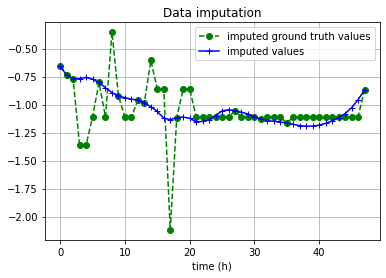

In [262]:
man = randint(0, imputed.shape[0]-1)
health_param = randint(0, imputed.shape[2]-1)
print(f'Patient {man}, health parameter {health_param}')
fig, ax = plt.subplots()
ax.plot(imputed[man,:, health_param], linestyle='--', marker='o', color='green', label='imputed ground truth values')
ax.plot(imputed_no_gt[man,:, health_param], linestyle='-', marker='+', color='blue', label='imputed values')
ax.set(xlabel='time (h)', title='Data imputation')
ax.grid()
ax.legend()
plt.show()
fig.savefig("Imputation.png")